In [38]:
class Config:
    name = "LGBM/Avg"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None
    
    # Reka Env
    dir_path = '/home/abe/kaggle/kaggle-amex'

In [39]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-pastel')
import seaborn as sns
sns.set_palette("winter_r")

from tqdm.auto import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')

In [40]:
INPUT = os.path.join(Config.dir_path, 'input')
OUTPUT = os.path.join(Config.dir_path, 'output')
SUBMISSION = os.path.join(Config.dir_path, 'submissions')
OUTPUT_EXP = os.path.join(OUTPUT, Config.name)
EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

# make dirs
for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
    os.makedirs(d, exist_ok=True)

In [41]:
train = pd.read_parquet(os.path.join(INPUT, 'train_small.parquet'))
target = pd.read_csv(os.path.join(INPUT, 'train_labels.csv'), dtype={'customer_ID': 'str', 'target': 'int8'})
# train = pd.read_parquet(os.path.join(INPUT, 'train_small.parquet') if COLAB else 'train_small.parquet')
test = pd.read_parquet(os.path.join(INPUT, 'test_small.parquet'))

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11916 entries, 0 to 11915
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(9), int8(86), object(2)
memory usage: 5.6+ MB


In [43]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,acca08966d77f76fca5d89fb223de5e8cdf19664f75bc3...,2017-03-20,0.877477,1,0.139729,0.069423,0.003938,0.152629,0.0,0.195161,...,-1,-1,-1,0,0,0.0,NaN,0,0.003734,0
1,acca08966d77f76fca5d89fb223de5e8cdf19664f75bc3...,2017-04-19,0.886986,1,0.145491,0.064216,0.006400,0.152880,0.0,0.194179,...,-1,-1,-1,0,0,0.0,NaN,0,0.009270,0
2,acca08966d77f76fca5d89fb223de5e8cdf19664f75bc3...,2017-05-13,0.927263,0,0.150889,0.064286,0.000217,0.161235,0.0,0.190367,...,-1,-1,-1,0,0,0.0,NaN,0,0.003613,0
3,acca08966d77f76fca5d89fb223de5e8cdf19664f75bc3...,2017-06-19,0.901115,1,0.173486,0.057740,0.001077,0.322572,0.0,0.246030,...,-1,-1,-1,0,0,0.0,NaN,0,0.005406,0
4,acca08966d77f76fca5d89fb223de5e8cdf19664f75bc3...,2017-07-05,0.900431,17,0.186169,0.052176,0.006668,0.334216,0.0,0.241392,...,-1,-1,-1,0,0,0.0,NaN,0,0.008058,0


## Evaluation merics

In [44]:
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

## Feature Eng

In [45]:
cat_features = [
    'B_30',
    'B_38',
    'D_114',
    'D_116',
    'D_117',
    'D_120',
    'D_126',
    'D_63',
    'D_64',
    'D_66',
    'D_68']
cont_features = [col for col in train.columns if col not in cat_features +
                 [Config.target, 'S_2', 'customer_ID']]

In [46]:
def _add_diff_features(args, step=3):
    customer_id, df = args
    dfs = []
    for i in range(step):
        shift = i + 1
        df_diff = df[cont_features].diff(shift).rename(
            columns={f: f"{f}_diff{shift}" for f in cont_features})
        df_diff = df_diff.tail(1).reset_index(drop=True)
        dfs.append(df_diff)
    df = pd.concat(dfs, axis=1)
    df['customer_ID'] = customer_id
    return df


def add_diff_features(df: pd.DataFrame, processes=32):
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(
            _add_diff_features,
            df.groupby('customer_ID'))
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df.reset_index(drop=True).sort_index(axis=1)


train_diff = add_diff_features(
    train.copy()).merge(
        target,
        how='left',
    on='customer_ID')
test_diff = add_diff_features(test.copy())

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso


def select_cont_features(df: pd.DataFrame, features, target, max_features=150):
    features_list = []
    train_y = df[target]
    train_X = df[features]

    train_X = train_X.replace([np.inf, -np.inf], np.nan)
    train_X = train_X.fillna(-999)

    # select features with L1 norm
    scaler = StandardScaler()
    scaler.fit(train_X)
    for alpha in [3e-3, 5e-3, 7e-3, 1e-2, 3e-2]:
        selector = SelectFromModel(
            Lasso(
                alpha=alpha),
            max_features=max_features)
        selector.fit(scaler.transform(train_X), train_y)
        selected_features = train_X.columns.values[selector.get_support()]
        features_list.append(selected_features)
        print('number of selected features : {}'.format(len(selected_features)))

    return features_list

print('======= select diff features =======')
features = [
    col for col in train_diff.columns if col not in [
        'customer_ID',
        Config.target]]
diff_features_list = select_cont_features(train_diff, features, Config.target)

======= select diff features =======
number of selected features : 62
number of selected features : 46
number of selected features : 37
number of selected features : 28
number of selected features : 17


In [48]:
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']

def add_features(df):
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1))
    df_avg = (df
              .groupby(cid)
              .mean()[features_avg]
              .rename(columns={f: f"{f}_avg" for f in features_avg})
             )
    gc.collect()
    df_min = (df
              .groupby(cid)
              .min()[features_min]
              .rename(columns={f: f"{f}_min" for f in features_min})
             )
    gc.collect()
    df_max = (df
              .groupby(cid)
              .max()[features_max]
              .rename(columns={f: f"{f}_max" for f in features_max})
             )
    gc.collect()
    df = (df.loc[last, features_last]
          .rename(columns={f: f"{f}_last" for f in features_last})
          .set_index(np.asarray(cid[last]))
         )
    gc.collect()
    df = pd.concat([df, df_min, df_max, df_avg], axis=1)
    del df_avg, df_min, df_max, cid, last
    return df

train = add_features(train).join(target.set_index('customer_ID'), how='left')
test = add_features(test)

## Select features to use

In [49]:
def get_faetures(df):
    unuse = ['customer_ID', 'S_2', 'target']
    features = [col for col in df.columns if col not in unuse]
    return features

## Training

In [50]:
from lightgbm.plotting import plot_metric
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold


def fit_lgbm(X, y, params=None):
    models = []
    scores = []

    skf = StratifiedKFold(
        n_splits=Config.n_splits,
        shuffle=True,
        random_state=Config.seed)

    for fold, (train_indices, valid_indices) in enumerate(
            skf.split(X, y)):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

        model = LGBMClassifier(**params,
                               boosting_type='gbdt',
                               objective='binary',
                               n_estimators=1200,
                               random_state=Config.seed,
                               force_col_wise=True,
                               n_jobs=16,
                               verbose=-1)
        
        model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_names=['train', 'valid'],
                      eval_metric=[lgb_amex_metric],
                      # callbacks=[early_stopping(stopping_rounds=20, verbose=1)],
                      verbose=0)

        # ------------------- prediction -------------------
        pred = model.predict_proba(X_valid, raw_score=True)
        score = amex_metric(y_valid, pred)

        # ------------------- save -------------------
        scores.append(score)
        models.append(model)
        print(f'fold{fold} amex meric: {score}')

    print(f"OOF Score: {np.mean(scores):.5f}")
    return models, np.mean(scores)


def inference_lgbm(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred


In [51]:
lgb_params = {"learning_rate": 0.03,
              'reg_lambda': 50,
              'min_child_samples': 2400,
              'num_leaves': 95,
              "metric" : "None",
              'max_bin': 511}

best_score = 0
best_models = []
best_features = []
for i, diff_features in enumerate(diff_features_list):
    data = train.join(train_diff[list(diff_features) +
                                 ['customer_ID']].set_index('customer_ID'), how='left')
    features = get_faetures(data)
    print('#'*25)
    print('### Trial',i)
    print('### Training with {} features'.format(len(features)))
    print('#'*25)
    
    models, score = fit_lgbm(data[features], data[Config.target], params=lgb_params)
    if score > best_score:
        best_models = models
        best_features = features

del train, train_diff

test = test.join(test_diff.set_index('customer_ID'), how='left')[best_features]
pred = inference_lgbm(best_models, test[best_features])

#########################
### Trial 0
### Training with 531 features
#########################
fold0 amex meric: 0.11973988057366532
fold1 amex meric: -0.06862059640315772
fold2 amex meric: 0.032154050998359184
fold3 amex meric: 0.09177738803170465
fold4 amex meric: 0.032979514293979786
OOF Score: 0.04161
#########################
### Trial 1
### Training with 515 features
#########################
fold0 amex meric: 0.11973988057366532
fold1 amex meric: -0.06862059640315772
fold2 amex meric: 0.032154050998359184
fold3 amex meric: 0.09177738803170465
fold4 amex meric: 0.032979514293979786
OOF Score: 0.04161
#########################
### Trial 2
### Training with 506 features
#########################
fold0 amex meric: 0.11973988057366532
fold1 amex meric: -0.06862059640315772
fold2 amex meric: 0.032154050998359184
fold3 amex meric: 0.09177738803170465
fold4 amex meric: 0.032979514293979786
OOF Score: 0.04161
#########################
### Trial 3
### Training with 497 features
##########

## Plot importances

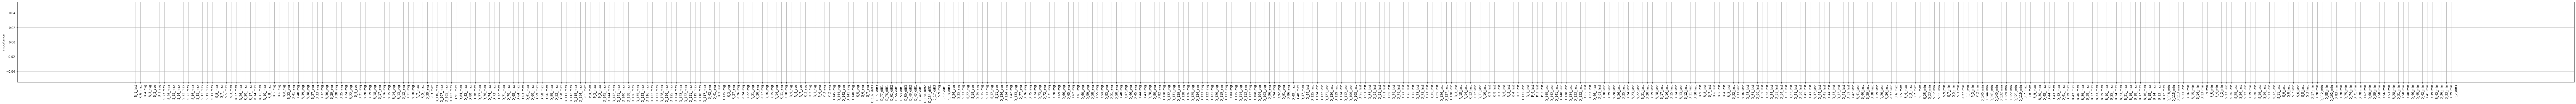

In [52]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.savefig(os.path.join(EXP_FIG, 'importance.png'))

plot_importances(best_models)

## Submission

In [53]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': pred})
sub.to_csv(f'{SUBMISSION}/diff.csv', index=False)